### <b> This notebook shows slices of inverted pendulum state space with phase portraits

In [2]:
import matplotlib.pyplot as plt
from numpy import sin, cos
import numpy as np
import matplotlib as mpl
import itertools as it
from scipy import integrate

In [3]:
# Converts values in array to indexes
# or: numpy.where()
from math import ceil
def get_idx_from_vals(maxv, minv, step, value):
    '''
        Konwertuje wartość zmiennej na jej indeks w odpowiadającej jej tablicy
        np. x_arr = [1.2, 1.4, 1.6, 1.8]
            get_idx_from_vals(1.4) >>> returns: idx = 1 
    '''
    arr_len = (maxv - minv) / step + 1
    slope = (arr_len - 1) / (maxv - minv)
    idx = lambda elem: ceil(slope*(elem - minv))
    
    idx = ceil(slope*(value - minv))
    
    return idx

# eg. use #
if 0:
    temp = np.arange(-3, 1.1, 0.1)
    disp(list( enumerate(temp) )[30:37])
    print('number .5 index is: ', get_idx_from_vals(1, -3, 0.1, 0.5))

In [4]:
# function for scipy.odeint -> sample trajectories
def ddt_state(state, t, u_func, params):
    '''
        Function used for scipy.integrate.odeint to generate sample state trajectory (ode solution)
        state = ( x  theta  Dx  Dtheta )
                ( x1  x2    x3    x4   )
    '''
    x1, x2, x3, x4 = state
    M, mc, mp, Lp, Lc, g, b, gamma, D, alpha, mr, Mt, L, Jcm, Jt = params

    u=u_func(t)
    den = Jt*Mt - L**2 * mr**2 * cos(x2)

    ddt_x1 = x3
    ddt_x2 = x4
    ddt_x3 = ( Jt*(D*cos(alpha) + L*mr*x4**2*sin(x2) - b*x3 + u) - \
                L*mr*cos(x2) * ( D*( L*cos(alpha-x2) + sin(alpha+np.pi/4) ) + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / den
    
    ddt_x4 = ( -L*mr*cos(x2) * (D*cos(alpha) + L*mr*x4**2*sin(x2) - b*x3 + u) + \
                Mt * ( D*( L*cos(alpha-x2) + sin(alpha+np.pi/4) ) + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / den
    
    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4)

In [5]:
# Returns state functions to calculate vector field
def ddt_states_for_v_field(params):
    ''' 
        x1    x2      x3      x4
        x    theta    Dx    Dtheta
        
        Returns 4 state functions ddt_x1 ddt_x2 ddt_x3 ddt_x4 as a function of state (u=0).
        These 4 functions can be used to generate slices of 4D vector field (of 4D state space)
        
        ddt_x1 is not a function of any state except x3 so:
            x1(x3) - constant slope
            (has constant slope and x1 intercept depends on initial conditions) 
        
        ddt_x2 - the same as in ddt_x1 case:
            x2(x4) - constant slope
    '''
    M, mc, mp, Lp, Lc, g, b, gamma, D, alpha, mr, Mt, L, Jcm, Jt = params

    u=0
    
    def ddt_x1(x1, x2, x3, x4):
        return x3
    def ddt_x2(x1, x2, x3, x4):
        return x4
    def ddt_x3(x1, x2, x3, x4):
        u=0
        ret = ( Jt*(D*cos(alpha) + L*mr*np.power(x4, 2)*sin(x2) - b*x3 + u) - \
                L*mr*cos(x2) * ( D*( L*cos(alpha-x2) + sin(alpha+np.pi/4) ) + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / (Jt*Mt - L**2 * mr**2 * cos(x2))
        return ret
    
    def ddt_x4(x1, x2, x3, x4):
        u=0
        ret = ( -L*mr*cos(x2) * (D*cos(alpha) + L*mr*np.power(x4, 2)*sin(x2) - b*x3 + u) + \
                Mt * ( D*( L*cos(alpha-x2) + sin(alpha+np.pi/4) ) + L*g*mr*sin(x2) - gamma*x4 ) ) \
                / (Jt*Mt - L**2 * mr**2 * cos(x2))
        return ret

    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4) 

In [6]:
# Function for calculations and stuff
def calculate_all_the_stuff_you_will_need(deg_theta_step,   # step in theta direction in degrees
                                          deg_Dtheta_step,  # step in Dtheta direction in degrees
                                          xlims,            # plot x limits
                                          ylims,            # plot y limits
                                          which_x1,         
                                          which_x3,
                                          scale,
                                          x1_lims,
                                          x3_lims,
                                          x1_step,
                                          x3_step):
    '''
        Params : deg_theta_step, 
                 deg_Dtheta_step, 
                 xlims, ylims,
                 which_x1,
                 which_x3,
                 scale
        Return : xx,
                 yy,
                 uu,
                 vv,
                 x2_coord,
                 x4_coord
    '''
    x1_v_step, x2_v_step, x3_v_step, x4_v_step = (x1_step, deg_theta_step*np.pi/180, x3_step, deg_Dtheta_step*np.pi/180)

    # Radian limits to degree limits
    xlims_rad = xlims * np.pi / 180
    ylims_rad = ylims * np.pi / 180

    # Coordinates arrays used to make coordinates matrices
    x1_coord = np.arange(x1_lims[0], x1_lims[1]+x1_v_step, x1_v_step)    # x
    x2_coord = np.arange(xlims_rad[0], xlims_rad[1]+x2_v_step, x2_v_step)    # theta
    x3_coord = np.arange(x3_lims[0], x3_lims[1]+x3_v_step, x3_v_step)    # Dx
    x4_coord = np.arange(ylims_rad[0], ylims_rad[1]+x4_v_step, x4_v_step)    # Dtheta

    # Coordinate matrices for 4D space
    x1_c_mat, x2_c_mat, x3_c_mat, x4_c_mat = np.meshgrid(x1_coord, x2_coord, x3_coord, x4_coord, indexing='ij')

    d_x1_f, d_x2_f, d_x3_f, d_x4_f = ddt_states_for_v_field(params=params)

    # d = direction matrices = elements of vector field
    # eq. d1 contain all x values of vec. field for whole 4D grid
    d1 = d_x1_f(x1_c_mat, x2_c_mat, x3_c_mat, x4_c_mat)
    d2 = d_x2_f(x1_c_mat, x2_c_mat, x3_c_mat, x4_c_mat)
    d3 = d_x3_f(x1_c_mat, x2_c_mat, x3_c_mat, x4_c_mat)
    d4 = d_x4_f(x1_c_mat, x2_c_mat, x3_c_mat, x4_c_mat)

    # Convert results in radians to results in degrees
    x2_c_mat = x2_c_mat * 180/np.pi
    x4_c_mat = x4_c_mat * 180/np.pi
    d2 = d2 * 180/np.pi
    d4 = d4 * 180/np.pi

    # Get slices of a vector filed
    # With 'ij' indexing defined in np.meshgrid, indexing works like this:
    # array[1, :, 2, :] -> get all values of an array for x1=1 and x2=2
    xx = x2_c_mat[which_x1, :, which_x3, :]
    yy = x4_c_mat[which_x1, :, which_x3, :]

    uu = d2[which_x1, :, which_x3, :]
    vv = d4[which_x1, :, which_x3, :]

    # Normalization of vector field
    vec_len = np.sqrt( np.power(uu, 2) + np.power(vv, 2) )

    uu = uu/vec_len * scale
    vv = vv/vec_len * scale
    
    return (xx, yy, uu, vv, x2_coord, x4_coord, x1_coord, x3_coord)

In [146]:

# Constants and params
M = 0.1; mc = 0.1; mp = 0.1
Lc = 0.8; Lp = 0.4
g = 9.81
b = 3 # 0.001;
gamma = 0.5 #0.005
D = 0
alpha = 0
mr = mc+mp
Mt = mr + M
L  = (Lc*mc + Lp*mp) / mr
Jcm = (L**2)*mr + (Lc**2)*mc + 4/3 * (Lp**2)*mp
Jt  = Jcm + mr*L**2

params = (M, mc, mp, Lp, Lc, g, b, gamma, D, alpha, mr, Mt, L, Jcm, Jt)

### <b> Dla $\dot{\theta}$ vs $\theta$

In [156]:

# "interface"
########################################################################
# min max values for state variables
x_min, x_max        = (0, 10)
deg_theta_min_max   = np.array([-450, 450])
Dx_min, Dx_max      = (-4, 5)   
deg_Dtheta_min_max  = np.array([-300, 300])

x_step          = 1
deg_theta_step  = 15
Dx_step         = 1
deg_Dtheta_step = 15

grid_tick_step  = 50    # choose appropriately with xlim and ylim

scale = 5 # scales the vectors after normalization

#####################################################################
# FOR WHICH VALUES OF X AND DX TO PLOT V.FIELDS & STREAM PLOTS
#####################################################################
x_value = 0
Dx_values = [ 4, 1 ] 

u_func = lambda t: 0

########################################################################
# deg -> rad
rad_theta_step      = deg_theta_step        * np.pi/180
rad_Dtheta_step     = deg_Dtheta_step       * np.pi/180
rad_theta_min_max   = deg_theta_min_max     * np.pi/180
rad_Dtheta_min_max  = deg_Dtheta_min_max    * np.pi/180


x_coord             = np.arange(x_min, x_max+x_step, x_step)                                                            # x 
theta_coord_rad     = np.arange(rad_theta_min_max[0], rad_theta_min_max[1]+rad_theta_step, rad_theta_step)              # theta
Dx_coord            = np.arange(Dx_min, Dx_max+Dx_step, Dx_step)                                                        # Dx
Dtheta_coord_rad    = np.arange(rad_Dtheta_min_max[0], rad_Dtheta_min_max[1]+rad_Dtheta_step, rad_Dtheta_step)          # Dtheta

# Coordinate matrices in radians
# 4 axes for each state variable
x_cmat, theta_cmat, Dx_cmat, D_theta_cmat = np.meshgrid(x_coord, theta_coord_rad, Dx_coord, Dtheta_coord_rad, indexing='ij')

d_x1_f, d_x2_f, d_x3_f, d_x4_f = ddt_states_for_v_field(params=params)

dir_x       = d_x1_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_theta   = d_x2_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dx      = d_x3_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dtheta  = d_x4_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)

# For ploting coordinate matrices have to be converted to radians
# rad -> deg
theta_cmat      = theta_cmat    * 180/np.pi
D_theta_cmat    = D_theta_cmat  * 180/np.pi
dir_theta       = dir_theta     * 180/np.pi
dir_Dtheta      = dir_Dtheta    * 180/np.pi

In [157]:
# Normalization
vec_len = np.sqrt( np.power(dir_x, 2) + np.power(dir_theta, 2) + np.power(dir_Dx, 2) + np.power(dir_Dtheta, 2) )
dir_x       = dir_x/vec_len * scale
dir_theta   = dir_theta/vec_len * scale
dir_Dx      = dir_Dx/vec_len * scale
dir_Dtheta  = dir_Dtheta/vec_len * scale

C:\Users\Adam\AppData\Local\Temp\ipykernel_12876\3949781548.py:14: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


4
4

1
1



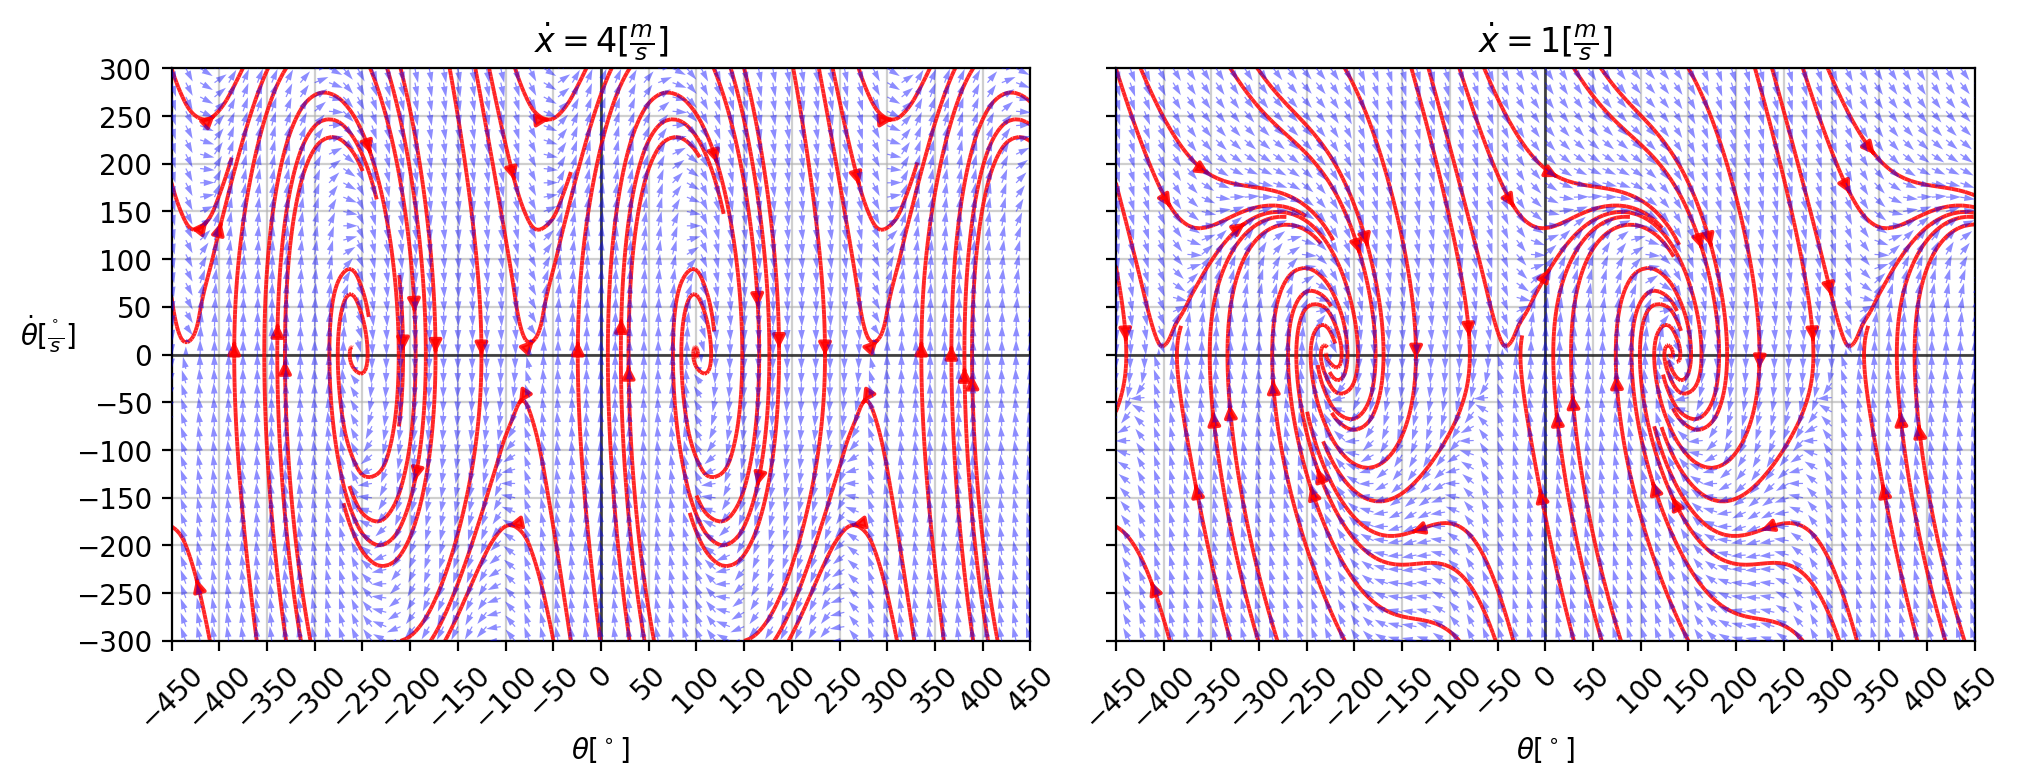

In [165]:
# D_THETA VS THETA, plus streamlines
# Coordinate matrices: x_cmat, theta_cmat, Dx_cmat, Dtheta_cmat
# Directions matrices: dir_x, dir_theta, dir_Dx, dir_Dtheta


fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(10, 4), dpi=200, sharey=True, sharex=True, layout="compressed")
# fig.tight_layout(h_pad=0.15, w_pad=0.5)
left  = 0.1  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.1   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

xlabel=r'$\theta [ ^\circ ]$'
ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

# uncomment only when plotting one plot 
if not isinstance(ax, np.ndarray):
    ax = np.array([ax, ])
    
# set y label only for left most plot 
ax[0].set_ylabel(ylabel, labelpad=10, rotation=0)     
for axes in ax:
    axes.set_xlabel(xlabel, labelpad=0)
ax = ax.flatten()

for axes in ax:
    axes.set_aspect('equal')
    axes.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
    axes.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)

    axes.set_xlim(deg_theta_min_max)
    axes.set_ylim(deg_Dtheta_min_max)
    
    axes.grid(zorder=0, alpha=0.6)

    axes.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
    axes.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])

    axes.tick_params(axis='x', rotation=45)
    

#####################################################################
for i, Dx in enumerate(Dx_values):
    
    Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
    ax[i].set_title(r'$\dot{x} = $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')


    # te liczby powinny być takie same albo bardzo blisko siebie
    print( Dx_coord[Dx_idx] )
    print( Dx )
    print()
    
    # x theta Dx Dtheta
    ax[i].quiver(theta_cmat[x_value, :, Dx_idx, :], 
                 D_theta_cmat[x_value, :, Dx_idx, :],
                 dir_theta[x_value, :, Dx_idx, :],
                 dir_Dtheta[x_value, :, Dx_idx, :],
                 angles='xy', scale_units='xy',
                 scale=0.32,
                 width=0.0014,       # szerokość pręta
                 headwidth=5.5,
                 headaxislength=9,  # wcięcie
                 headlength=9,
                 color='blue',
                 zorder=10,
                 alpha=0.45)

    ax[i].streamplot(theta_cmat[x_value, :, Dx_idx, :].T, 
                     D_theta_cmat[x_value, :, Dx_idx, :].T,
                     dir_theta[x_value, :, Dx_idx, :].T,
                     dir_Dtheta[x_value, :, Dx_idx, :].T,
                     density=4, 
                     color=[1, 0, 0, 0.85],
                     linewidth=1.4,
                     arrowsize=0.9, 
                     zorder=2,
                     maxlength=10,
                     minlength=0.2,
                     broken_streamlines=True,
                     start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
    )

fig.savefig('C:\\Users\\Adam\\Desktop\\inzyniera\\01_PRACA\\obrazki\\portrety_fazowe\\cos.png',
             dpi=500)

# plt.show()b

In [139]:
fig.savefig('C:\\Users\\Adam\\Desktop\\inzyniera\\01_PRACA\\obrazki\\portrety_fazowe\\cos.png',
             dpi=500)